# National Health and Nutrition Examination Survey (NHANES) Chronic Disease Prevalence VS Harvard PGP Study Population
https://www.cdc.gov/nchs/nhanes/about_nhanes.htm

In [380]:
# TODO:
#1. Make statement about how the data was collected, who was interviewed?
#2. Assess at least 10 conditions
#3. Create table comparing condition rates between the two populations

# #1 Info about study population form  NHANES Site


### "The National Health and Nutrition Examination Survey (NHANES) is a program of studies designed to assess the health and nutritional status of adults and children in the United States. The survey is unique in that it combines interviews and physical examinations. NHANES is a major program of the National Center for Health Statistics (NCHS). NCHS is part of the Centers for Disease Control and Prevention (CDC) and has the responsibility for producing vital and health statistics for the Nation."

### **Important: "The sample for the survey is selected to represent the U.S. population of all ages. To produce reliable statistics, NHANES over-samples persons 60 and older, African Americans, and Hispanics."

### How the rates were collected
### - All reported occurences of condition are in response to question: "Ever been told you have  ________"

In [379]:
# import sys
# !{sys.executable} -m pip install sas7bdat

In [375]:
import pandas as pd
import pyreadstat
import sas7bdat
import psycopg2
import io
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [23]:
def read_xpt(fpath):
    data, metadata = pyreadstat.read_xport(fpath)
    df = pd.DataFrame(data)
    return df


In [22]:
#Diabetes

In [24]:
fpath = '/Users/jerenolsen/Desktop/All_Tests/NHANES/Diabetes_DIQ_J.XPT'
df = read_xpt(fpath)

In [25]:
df

,SEQN,DIQ010,DID040,DIQ160,DIQ170,DIQ172,DIQ175A,DIQ175B,DIQ175C,DIQ175D,...,DIQ300D,DID310S,DID310D,DID320,DID330,DID341,DID350,DIQ350U,DIQ360,DIQ080
0,93703.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,93704.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,93705.0,2.0,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,93706.0,2.0,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,93707.0,2.0,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8892,102952.0,3.0,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8893,102953.0,2.0,NaN,1.0,2.0,1.0,NaN,11.0,NaN,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8894,102954.0,2.0,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8895,102955.0,2.0,NaN,2.0,2.0,1.0,NaN,11.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Note: the National Health and Nutrition Examination survey data files (in XPT format) are too cumbersome to use and relate to the code tables listed on the site (Would require webscraping or a lot of copy paste) for such a short analysis. Instead will just copy paste the disease rate tables on codes pages (see source links below)

In [317]:
def run_pg_query(search_term):
    
    def get_password(txt_path):
        with open(txt_path,'r') as f:
            for line in f:
                password=line.strip('\n')
        return password
                
    password=get_password('/Users/jerenolsen/Desktop/password.txt')
                    
    db_params = {
    "host": "localhost",
    "port": "5432",
    "database": "etl-testing",
    "user": "postgres",
    "password": "{password}".format(password=password)
    }
    
    query = """
            SELECT DISTINCT person_id, min(val)
            FROM (
                SELECT person_id, condition_source_value AS val
                FROM cdm.condition_occurrence
                UNION ALL
                SELECT person_id, observation_source_value AS val
                FROM cdm.observation
            ) AS combined_table
            WHERE val ILIKE '%{search_term}%'
            GROUP BY person_id;
            """.format(search_term=search_term)
    
    try:

        connection = psycopg2.connect(**db_params)
        cursor = connection.cursor()

        cursor.execute(query)
        data = cursor.fetchall()
        column_names = [desc[0] for desc in cursor.description]

        df = pd.DataFrame(data, columns=column_names)

        cursor.close()
        connection.close()
        
        print(f"Query results for {search_term}:\n> Conditons:\n {df['min'].value_counts()}\n> Total hits: {len(df)}\n")

        return df

    except (Exception, psycopg2.Error) as error:
        print("Error while connecting to PostgreSQL or executing query:", error)
        return None
    
def process_NHANES(data_str):
    data_stream = io.StringIO(data_str)
    df = pd.read_csv(data_stream, sep='\t')
    df.drop(columns=['Skip to Item'], inplace=True)
    print(df,'\n')
    
    rate = df.iloc[0]['Count']/df.iloc[1]['Cumulative']

    return rate
    

def init_disease_rate():
    disease_rates = pd.DataFrame()
    disease_rates['Condition'] = None
    disease_rates['NHANES_rate'] = None
    disease_rates['HVD_PGP_rate'] = None
    return disease_rates


def update_rates(disease_rates, name, n_rate, h_rate):
    df = pd.DataFrame()
    df['Condition'] = [name]
    df['NHANES_rate'] = [n_rate]
    df['HVD_PGP_rate'] = [h_rate]
    
    print(f"Updating rates for {name}:\n{df}\n")
    
    disease_rates = pd.concat([disease_rates,df])
    return disease_rates

<!-- SELECT DISTINCT person_id
FROM (
	SELECT person_id, condition_source_value AS val
	FROM cdm.condition_occurrence
	UNION ALL
	SELECT person_id, observation_source_value AS val
	FROM cdm.observation
) AS combined_table
WHERE val ILIKE '%diab%'; -->

In [319]:
#Global harvard pgp population size
N_HVD_PGP = 900

In [ ]:
disease_rates = init_disease_rate()

# Hypertension

Source: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/BPQ_J.htm#BPQ020

In [320]:
condition_name = 'Hypertension'

In [321]:
NHANES = """Code or Value	Value Description	Count	Cumulative	Skip to Item
1	Yes	2137	2137	
2	No	4014	6151"""

In [322]:
n_rate = process_NHANES(NHANES)
h_rate = len(run_pg_query(condition_name))/N_HVD_PGP
disease_rates = update_rates(disease_rates, name = condition_name, n_rate = n_rate, h_rate = h_rate)

   Code or Value Value Description  Count  Cumulative
0              1               Yes   2137        2137
1              2                No   4014        6151 

Query results for Hypertension:
> Conditons:
 Hypertension                                          117
Benign hypertension                                     4
Essential Hypertension                                  3
Pulmonary Hypertension                                  2
Prehypertension                                         2
Chest Pain, Acute hypertension                          1
HTN (hypertension)                                      1
Essential Stage I hypertension, Despite Medication      1
Name: min, dtype: int64
> Total hits: 131

Updating rates for Hypertension:
      Condition  NHANES_rate  HVD_PGP_rate
0  Hypertension     0.347423      0.145556



# DIABETES

Source: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DIQ_J.htm#DIQ010

In [323]:
condition_name = 'Diabetes'

In [275]:
NHANES = """Code or Value	Value Description	Count	Cumulative	Skip to Item
1	Yes	893	893	
2	No	7816	8709	DIQ159"""

In [324]:
n_rate = process_NHANES(NHANES)
h_rate = len(run_pg_query(condition_name))/N_HVD_PGP
disease_rates = update_rates(disease_rates, name = condition_name, n_rate = n_rate, h_rate = h_rate)

   Code or Value Value Description  Count  Cumulative
0              1               Yes   2137        2137
1              2                No   4014        6151 

Query results for Diabetes:
> Conditons:
 Diabetes mellitus            36
Prediabetes                   2
DIABETES MELLITUS             2
Diabetes mellitus, type 2     1
Type 2 Diabetes               1
diabetes type 2               1
Diabetes Insipidus            1
Name: min, dtype: int64
> Total hits: 44

Updating rates for Diabetes:
  Condition  NHANES_rate  HVD_PGP_rate
0  Diabetes     0.347423      0.048889



# Hepatitis

source: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/HEQ_J.htm

In [325]:
condition_name = 'Hepatitis B'

In [326]:
NHANES = """Code or Value	Value Description	Count	Cumulative	Skip to Item
1	Yes	57	57	
2	No	7798	7855	HEQ030"""

In [327]:
n_rate = process_NHANES(NHANES)
h_rate = len(run_pg_query(condition_name))/N_HVD_PGP
disease_rates = update_rates(disease_rates, name = condition_name, n_rate = n_rate, h_rate = h_rate)

   Code or Value Value Description  Count  Cumulative
0              1               Yes     57          57
1              2                No   7798        7855 

Query results for Hepatitis B:
> Conditons:
 Hepatitis B    2
Name: min, dtype: int64
> Total hits: 2

Updating rates for Hepatitis B:
     Condition  NHANES_rate  HVD_PGP_rate
0  Hepatitis B     0.007257      0.002222



In [328]:
condition_name = 'Hepatitis C'

In [329]:
NHANES = """
Code or Value	Value Description	Count	Cumulative	Skip to Item
1	Yes	99	99	
2	No	7749	7848	End of Section"""

In [330]:
n_rate = process_NHANES(NHANES)
h_rate = len(run_pg_query(condition_name))/N_HVD_PGP
disease_rates = update_rates(disease_rates, name = condition_name, n_rate = n_rate, h_rate = h_rate)

   Code or Value Value Description  Count  Cumulative
0              1               Yes     99          99
1              2                No   7749        7848 

Query results for Hepatitis C:
> Conditons:
 Chronic hepatitis C    1
Hepatitis C            1
Name: min, dtype: int64
> Total hits: 2

Updating rates for Hepatitis C:
     Condition  NHANES_rate  HVD_PGP_rate
0  Hepatitis C     0.012615      0.002222



# Osteoporosis

Source: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/OSQ_J.htm#OSQ060

In [335]:
condition_name = 'Osteoporosis'

In [336]:
NHANES = """Code or Value	Value Description	Count	Cumulative	Skip to Item
1	Yes	396	396	
2	No	2657	3053	OSQ130"""

In [337]:
n_rate = process_NHANES(NHANES)
h_rate = len(run_pg_query(condition_name))/N_HVD_PGP
disease_rates = update_rates(disease_rates, name = condition_name, n_rate = n_rate, h_rate = h_rate)

   Code or Value Value Description  Count  Cumulative
0              1               Yes    396         396
1              2                No   2657        3053 

Query results for Osteoporosis:
> Conditons:
 Osteoporosis               22
Idiopathic osteoporosis     1
Name: min, dtype: int64
> Total hits: 23

Updating rates for Osteoporosis:
      Condition  NHANES_rate  HVD_PGP_rate
0  Osteoporosis     0.129708      0.025556



# Asthma

SOURCE FOR ALL REMAINING QUERIES: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/MCQ_J.htm#MCQ010

In [338]:
condition_name = 'Asthma'

In [339]:
NHANES = """Code or Value	Value Description	Count	Cumulative	Skip to Item
1	Yes	1325	1325	
2	No	7563	8888	MCQ053"""

In [340]:
n_rate = process_NHANES(NHANES)
h_rate = len(run_pg_query(condition_name))/N_HVD_PGP
disease_rates = update_rates(disease_rates, name = condition_name, n_rate = n_rate, h_rate = h_rate)

   Code or Value Value Description  Count  Cumulative
0              1               Yes   1325        1325
1              2                No   7563        8888 

Query results for Asthma:
> Conditons:
 Asthma          114
ASTHMA           41
Mixed asthma      1
Acute asthma      1
Name: min, dtype: int64
> Total hits: 157

Updating rates for Asthma:
  Condition  NHANES_rate  HVD_PGP_rate
0    Asthma     0.149077      0.174444



# Arthritis

In [331]:
condition_name = 'Arthritis'

In [332]:
NHANES = """Code or Value	Value Description	Count	Cumulative	Skip to Item
1	Yes	1695	1695	
2	No	3857	5552	"""

In [333]:
n_rate = process_NHANES(NHANES)
h_rate = len(run_pg_query(condition_name))/N_HVD_PGP
disease_rates = update_rates(disease_rates, name = condition_name, n_rate = n_rate, h_rate = h_rate)

   Code or Value Value Description  Count  Cumulative
0              1               Yes   1695        1695
1              2                No   3857        5552 

Query results for Arthritis:
> Conditons:
 Osteoarthritis                                  85
Rheumatoid arthritis                            13
Arthritis                                        7
Rheumatoid Arthritis                             1
Generalized osteoarthritis of multiple sites     1
Advanced patellar osteoarthritis                 1
Juvenile Rheumatoid Arthritis (JRA)              1
Osteoarthritis of left shoulder                  1
Name: min, dtype: int64
> Total hits: 110

Updating rates for Arthritis:
   Condition  NHANES_rate  HVD_PGP_rate
0  Arthritis     0.305295      0.122222



In [341]:
disease_rates

,Condition,NHANES_rate,HVD_PGP_rate
0,Hypertension,0.347423,0.145556
0,Diabetes,0.347423,0.048889
0,Hepatitis B,0.007257,0.002222
0,Hepatitis C,0.012615,0.002222
0,Arthritis,0.305295,0.122222
0,Osteoporosis,0.129708,0.025556
0,Asthma,0.149077,0.174444


# Gout

In [342]:
condition_name = 'Gout'

In [343]:
NHANES = """
Code or Value	Value Description	Count	Cumulative	Skip to Item
1	Yes	338	338	
2	No	5222	5560	"""

In [344]:
n_rate = process_NHANES(NHANES)
h_rate = len(run_pg_query(condition_name))/N_HVD_PGP
disease_rates = update_rates(disease_rates, name = condition_name, n_rate = n_rate, h_rate = h_rate)

   Code or Value Value Description  Count  Cumulative
0              1               Yes    338         338
1              2                No   5222        5560 

Query results for Gout:
> Conditons:
 Gout                       23
Pseudogout                  1
Gout (2001, 2 episodes)     1
Name: min, dtype: int64
> Total hits: 25

Updating rates for Gout:
  Condition  NHANES_rate  HVD_PGP_rate
0      Gout     0.060791      0.027778



# Coronary Heart Disease

In [351]:
condition_name = 'coronary'

In [ ]:
NHANES = """Code or Value	Value Description	Count	Cumulative	Skip to Item
1	Yes	265	265	
2	No	5288	5553	"""

In [353]:
n_rate = process_NHANES(NHANES)
h_rate = len(run_pg_query(condition_name))/N_HVD_PGP
disease_rates = update_rates(disease_rates, name = condition_name, n_rate = n_rate, h_rate = h_rate)

   Code or Value Value Description  Count  Cumulative
0              1               Yes    338         338
1              2                No   5222        5560 

Query results for coronary:
> Conditons:
 Coronary Artery Disease (CAD)           1
Coronary artery abnormality ( ARCA )    1
Name: min, dtype: int64
> Total hits: 2

Updating rates for coronary:
  Condition  NHANES_rate  HVD_PGP_rate
0  coronary     0.060791      0.002222



# Emphysema

In [357]:
condition_name = 'Emphysema'

In [358]:
NHANES = """
Code or Value	Value Description	Count	Cumulative	Skip to Item
1	Yes	106	106	
2	No	5450	5556	"""

In [359]:
n_rate = process_NHANES(NHANES)
h_rate = len(run_pg_query(condition_name))/N_HVD_PGP
disease_rates = update_rates(disease_rates, name = condition_name, n_rate = n_rate, h_rate = h_rate)

   Code or Value Value Description  Count  Cumulative
0              1               Yes    106         106
1              2                No   5450        5556 

Query results for Emphysema:
> Conditons:
 Emphysema    4
Name: min, dtype: int64
> Total hits: 4

Updating rates for Emphysema:
   Condition  NHANES_rate  HVD_PGP_rate
0  Emphysema     0.019078      0.004444



# Bronchitis

In [360]:
condition_name = 'Bronchitis'

In [361]:
NHANES = """
Code or Value	Value Description	Count	Cumulative	Skip to Item
1	Yes	395	395	
2	No	5168	5563	"""

In [362]:
n_rate = process_NHANES(NHANES)
h_rate = len(run_pg_query(condition_name))/N_HVD_PGP
disease_rates = update_rates(disease_rates, name = condition_name, n_rate = n_rate, h_rate = h_rate)

   Code or Value Value Description  Count  Cumulative
0              1               Yes    395         395
1              2                No   5168        5563 

Query results for Bronchitis:
> Conditons:
 Chronic bronchitis    34
Bronchitis             5
Chronic Bronchitis     1
Name: min, dtype: int64
> Total hits: 40

Updating rates for Bronchitis:
    Condition  NHANES_rate  HVD_PGP_rate
0  Bronchitis     0.071005      0.044444



# Cancer

In [364]:
condition_name = 'Cancer'

In [365]:
NHANES = """Code or Value	Value Description	Count	Cumulative	Skip to Item
1	Yes	588	588	
2	No	4979	5567	MCQ300b"""

In [366]:
n_rate = process_NHANES(NHANES)
h_rate = len(run_pg_query(condition_name))/N_HVD_PGP
disease_rates = update_rates(disease_rates, name = condition_name, n_rate = n_rate, h_rate = h_rate)

   Code or Value Value Description  Count  Cumulative
0              1               Yes    588         588
1              2                No   4979        5567 

Query results for Cancer:
> Conditons:
 Non-melanoma skin cancer                              49
Cervical cancer                                        6
Breast Cancer                                          5
Prostate cancer                                        5
Breast cancer                                          4
Prostate Cancer                                        3
Endometrial cancer                                     3
Basal cell skin cancer                                 2
Thyroid cancer                                         2
Kidney cancer                                          2
Removal of ovary and borderline ovarian cancer tum     1
F/H PROSTATE CANCER                                    1
Kidney Cancer                                          1
Brain cancer                                           

In [367]:
disease_rates

,Condition,NHANES_rate,HVD_PGP_rate
0,Hypertension,0.347423,0.145556
0,Diabetes,0.347423,0.048889
0,Hepatitis B,0.007257,0.002222
0,Hepatitis C,0.012615,0.002222
0,Arthritis,0.305295,0.122222
0,Osteoporosis,0.129708,0.025556
0,Asthma,0.149077,0.174444
0,Gout,0.060791,0.027778
0,coronary,0.060791,0.002222
0,Emphysema,0.019078,0.004444


In [369]:
df = disease_rates

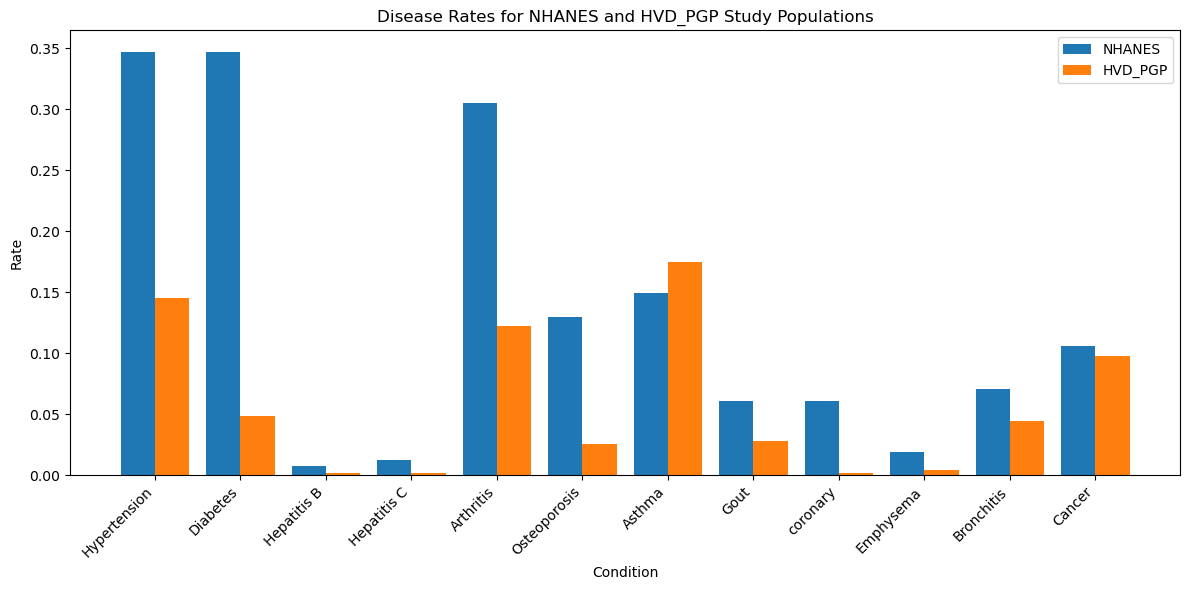

In [370]:
# Plot the grouped bar chart
plt.figure(figsize=(12, 6))
bar_width = 0.4
index = range(len(df))

plt.bar(index, df['NHANES_rate'], width=bar_width, label='NHANES')
plt.bar([i + bar_width for i in index], df['HVD_PGP_rate'], width=bar_width, label='HVD_PGP')

plt.xlabel('Condition')
plt.ylabel('Rate')
plt.title('Disease Rates for NHANES and HVD_PGP Study Populations')
plt.xticks([i + bar_width / 2 for i in index], df['Condition'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [372]:
condition_name='Gastroesophagea'
h_rate = len(run_pg_query(condition_name))/N_HVD_PGP

Query results for Gastroesophagea:
> Conditons:
 Gastroesophageal reflux disease (GERD)    117
Gastroesophageal Reflux Disease (GERD)     14
Gastroesophageal reflux disease             3
Name: min, dtype: int64
> Total hits: 134



In [373]:
h_rate

0.14888888888888888

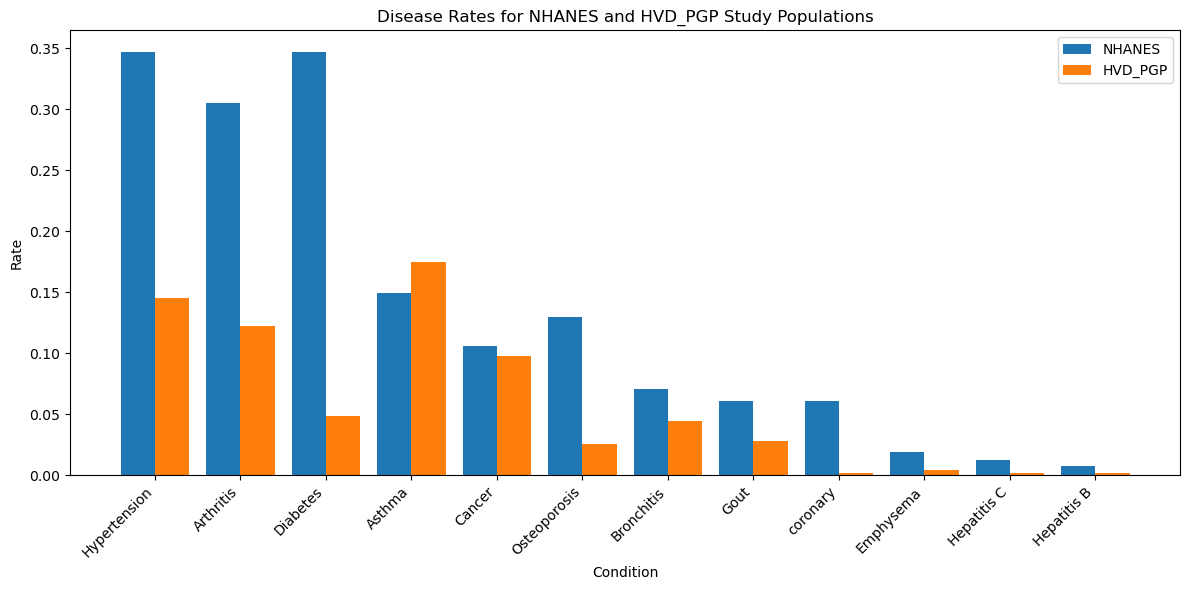

In [384]:
df['Overall_rate'] = df['NHANES_rate'] + df['HVD_PGP_rate']
df_sorted = df.sort_values(by='Overall_rate', ascending=False)

plt.figure(figsize=(12, 6))
bar_width = 0.4
index = range(len(df_sorted))

plt.bar(index, df_sorted['NHANES_rate'], width=bar_width, label='NHANES')
plt.bar([i + bar_width for i in index], df_sorted['HVD_PGP_rate'], width=bar_width, label='HVD_PGP')

plt.xlabel('Condition')
plt.ylabel('Rate')
plt.title('Disease Rates for NHANES and HVD_PGP Study Populations')
plt.xticks([i + bar_width / 2 for i in index], df_sorted['Condition'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [391]:
def run_pg_query(search_term,concept_set):
    
    def get_password(txt_path):
        with open(txt_path,'r') as f:
            for line in f:
                password=line.strip('\n')
        return password
                
    password=get_password('/Users/jerenolsen/Desktop/password.txt')
                    
    db_params = {
    "host": "localhost",
    "port": "5432",
    "database": "etl-testing",
    "user": "postgres",
    "password": "{password}".format(password=password)
    }
    
    query = """
            SELECT DISTINCT person_id, min(val)
            FROM (
                SELECT person_id, condition_source_value AS val, condition_concept_id as id
                FROM cdm.condition_occurrence
                UNION ALL
                SELECT person_id, observation_source_value AS val, observation_concept_id as id
                FROM cdm.observation
            ) AS combined_table
            WHERE id IN ({concept_set})
            GROUP BY person_id;
            """.format(concept_set = ','.join(map(str, concept_set)))
    
    try:

        connection = psycopg2.connect(**db_params)
        cursor = connection.cursor()

        cursor.execute(query)
        data = cursor.fetchall()
        column_names = [desc[0] for desc in cursor.description]

        df = pd.DataFrame(data, columns=column_names)

        cursor.close()
        connection.close()
        
        print(f"Query results for {search_term}:\n> Conditons:\n {df['min'].value_counts()}\n> Total hits: {len(df)}\n")

        return df

    except (Exception, psycopg2.Error) as error:
        print("Error while connecting to PostgreSQL or executing query:", error)
        return None

In [394]:
condition_name = 'Hypertension'
concept_set = [132685,134414,135601,136743,136760,137940,141084,141639,192684,197930,200157,201912,312648,314090,314103,314423,314958,316866,317895,317898,318437,319826,320128,320456,321074,321080,321638,433536,438490,439077,439393,441922,443771,762994,1340364,1340440,3656115,4006325,4023318,4028741,4028951,4032952,4034031,4034094,4034095,4048212,4049389,4057976,4057978,4057979,4058987,4061667,4062550,4062811,4062906,4071202,4080325,4083723,4094374,4108213,4110947,4110948,4118910,4146627,4146816,4148205,4151903,4159755,4162306,4167358,4167493,4174979,4178312,4179379,4180283,4199306,4209293,4212496,4215640,4217486,4218088,4219323,4221991,4227607,4242878,4249016,4253928,4262182,4263067,4269358,4276511,4277110,4279525,4283352,4289142,4289933,4291933,4302591,4304837,4305599,4311246,4316372,4321603,4322735,35622939,35624277,36713024,36715087,37016726,37208172,37208293,40481896,42538697,42538946,42873163,43020424,43021830,44783643,44783644,44784483,44784484,44809026,44809027,44809548,44809569,44811110,44811932,44811933,45757119,45757137,45757356,45757444,45757445,45757446,45757447,45757756,45757787,45757788,45768449,45771064,45771067]
NHANES = """Code or Value	Value Description	Count	Cumulative	Skip to Item
1	Yes	2137	2137	
2	No	4014	6151"""
n_rate = process_NHANES(NHANES)
h_rate = len(run_pg_query(search_term = condition_name, concept_set = concept_set))/N_HVD_PGP
disease_rates = update_rates(disease_rates, name = condition_name, n_rate = n_rate, h_rate = h_rate)

   Code or Value Value Description  Count  Cumulative
0              1               Yes   2137        2137
1              2                No   4014        6151 

Query results for Hypertension:
> Conditons:
 Hypertension                                          104
High blood pressure                                    18
Benign hypertension                                     4
Essential Hypertension                                  3
High blood potassium                                    1
HTN (hypertension)                                      1
Essential Stage I hypertension, Despite Medication      1
Name: min, dtype: int64
> Total hits: 132

Updating rates for Hypertension:
      Condition  NHANES_rate  HVD_PGP_rate
0  Hypertension     0.347423      0.146667

